In [1]:
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install seaborn
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 install statsmodels

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, ks_2samp
import statsmodels.api as sm
import statsmodels.formula.api as smf

In this blog post (also available via [my website](https://paulminogue.com/)) I will describe how we can use our understanding of the normal and poisson probability distributions to simulate gaelic football matches for Dublin's division 1 adult football league and determine the probability of either team winning the match.

I will begin by briefly summarising the rules of the game and how we can download the data required from the [Dublin GAA's website](https://www.dublingaa.ie/). From here I will discuss the normal and poisson distributions and how they can be used to calculate expected goals and points in a given match. Finally I will bring it all together and demonstrate how we can use these distributions to simulate matches and calculate win probabilities.

# A brief summary of Gaelic football and it's scoring system 

In case you are reading this blog and have no knowledge of Gaelic football, I will attempt to briefly summarise the sport and it's scoring system so you will have all the information required to continue with this tutorial.

Gaelic football is a sport where two teams of 15 play against each other to try accumalte the most points over the course of the match. Players can carry the ball with their hands but must bounce, or solo (drop the ball onto their foot and back up to their hand) every 4 steps. 

When it comes to scoring, teams can score in 2 ways:
1. Kicking the ball into the net for a goal - this is worth 3 points
2. Kicking or punching the ball over the crossbar for a point - this is worth one point

If you wish to learn more about the rules of Gaelic football, you can do so [here](https://www.gaa.ie/the-gaa/rules-regulations/)

# Import data 

The data used as part of this analysis was scraped from the latest results secton of the Dublin GAA website and contains results from all matches played in Dublin's senior adult division 1 league during the 2019 season. Rather than going into detail on this, as there is a lot to get through, I will summarise by saying that I essentially iterated through each row of the table on this website and pulled the scorelines for each match before saving them to the dataframe that I read in using pandas below.

This dataframe contains the results of all 99 fixtures from the 2019 division 1 season. It's worth noting that this is a pretty small results dataset but it will be enough for us to use when building some simulation models.

Once the data is read in, I create `total_goals` and `total_points` columns for each match. These columns will be used in the next section to understand how goals and points are distributed across games and will inform our modelling decisions later on.

If you would like more detail on how the data was scraped, I have prepared a jupyter notebook which goes through the steps involved and it is available within the git repo supporting this tutorial.

In [2]:
gaa_df = pd.read_pickle('data/dublin_gaa_results.pkl')

# create a game_id columns
gaa_df['game_id'] = gaa_df.index

# lets create total goals and points columns so we can plot the distribution
gaa_df['total_goals'] = gaa_df['home_team_goals'] + gaa_df['away_team_goals']
gaa_df['total_points'] = gaa_df['home_team_points'] + gaa_df['away_team_points']
gaa_df.head()

,date,time,location,home_team,home_team_goals,home_team_points,away_team,away_team_goals,away_team_points,game_id,total_goals,total_points
0,09 Nov,14:00,Martin Savage Park,St Oliver Plunketts ER,3,13,Templeogue Synge Street,1,9,0,4,22
1,23 Oct,19:30,Lawless Park,Fingallians,3,19,Na Fianna,3,15,1,6,34
2,19 Oct,16:00,Dolphin Park,Templeogue Synge Street,1,12,Cuala,4,14,2,5,26
3,19 Oct,16:00,St Mobhi Road,Na Fianna,0,9,St Oliver Plunketts ER,1,12,3,1,21
4,05 Oct,16:00,Hyde Park,Cuala,7,11,St Maurs,1,5,4,8,16


# Understanding how goals and points are distributed 

Before we can get stuck into any modelling, we will have to take a look at how points and goals are distributed across matches. For example while expect that points will be distributed normally, it is important that we confirm this as if they are actually distributed according to a poisson distribution and we fit a model under the assumption that they are normally distributed, our simulation results will be extremely inaccurate.

To do this we can use a goodness of fit test between the expected distribution, and the actual to determine if they differ significantly.

## Point distribution

Taking a look at the distribution of points across games visualised below, we can see that the distribution is very similar to the normal distribution overlaid in red. Of course it does not match exactly, however given the reasonably small sample size of games, that is understandable.

When we take a look at the goodness of fit test between the points distribution and the normal distribution, performed by using [scipy's ks_2samp function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) we can see that the p-value is much greater than $0.05$ and as a result of this we can assume going forward that our points data is normally distributed.

### Normal distribution goodness of fit 

In [3]:
mean_points = gaa_df['total_points'].mean()
points_std = gaa_df['total_points'].std()
normal_dist = np.random.normal(mean_points, points_std, 100000)

ks_2samp(np.array(gaa_df['total_points']), normal_dist)

Ks_2sampResult(statistic=0.0937287878787878, pvalue=0.34992454962173847)

### Visualise 

<ipython-input-4-740e0142a289>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


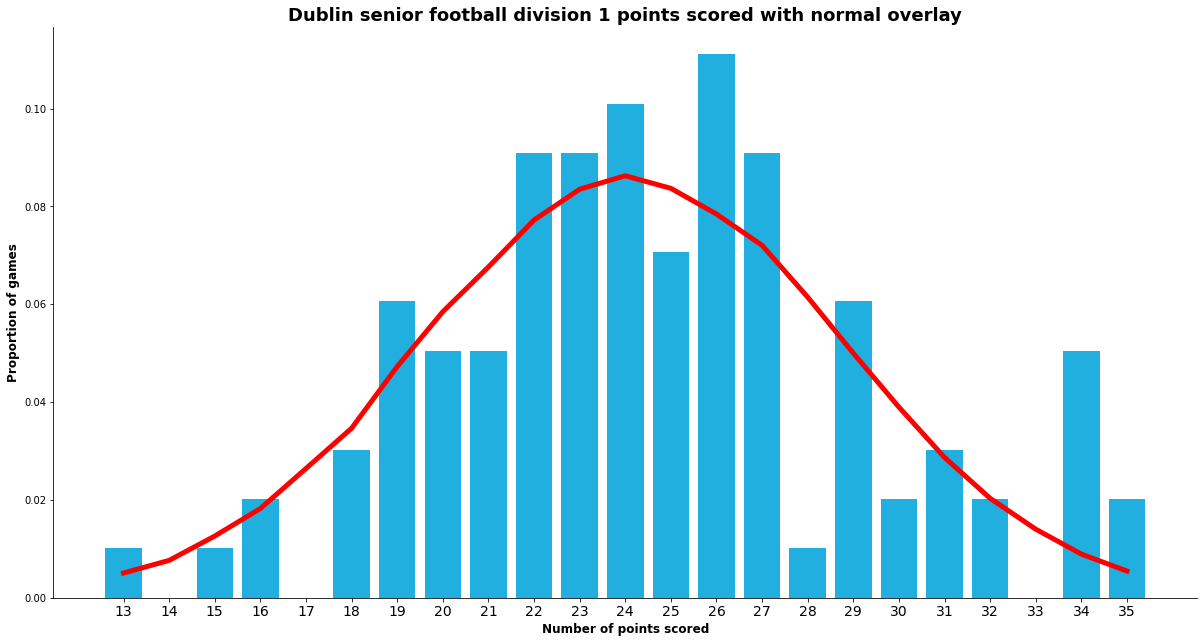

In [4]:
viz_df = gaa_df.groupby('total_points')['game_id'].count().reset_index()
viz_df.columns = ['total_points', 'number_of_matches']
viz_df['proportion_of_points'] = viz_df['number_of_matches']/len(gaa_df)

# point values we don't have data for that we need to add in
missing_data_points = []
for i in range(viz_df['total_points'].min(), viz_df['total_points'].max() +1):
    if i not in list(viz_df['total_points']):
        missing_data_points.append(
            {
                'total_points': i,
                'number_of_matches':0,
                'proportion_of_points':0
            }        
        )
        
missing_data = pd.DataFrame(missing_data_points)
viz_df = pd.concat([viz_df, missing_data])
viz_df = viz_df.sort_values(by='total_points').reset_index(drop=True)

# generate points distributed according to a normal distribution to overlay
mean_points = gaa_df['total_points'].mean()
points_std = gaa_df['total_points'].std()
normal_dist = pd.DataFrame({'total_points': list(np.random.normal(mean_points, points_std, 100000))}).reset_index()
normal_dist['total_points'] = normal_dist['total_points'].astype(int)
normal_dist = normal_dist.groupby('total_points')['index'].count().reset_index()
normal_dist['proportion_of_points'] = normal_dist['index']/100000
normal_dist = normal_dist.loc[normal_dist['total_points'].isin(viz_df['total_points'])]


fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot the distribution and overlay
ax = sns.barplot(
    x='total_points', y='proportion_of_points', data=viz_df, color='deepskyblue'
)

ax = sns.lineplot(
    x=ax.get_xticks(), y='proportion_of_points', data=normal_dist, color='red', linewidth=5
)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title("Dublin senior football division 1 points scored with normal overlay", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel("Number of points scored", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_ylabel("Proportion of games", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
plt.savefig('visuals/points_per_game.png')
fig.show()

## Goal distribution 

Conversely, when we take a look at our goal distribution we can seem that they appear to be distributed according to a poisson distribution, and in fact when we take a look at the goodness of fit test for this we can once again see a high p-value which indicates that goals are in fact distributed according to a poisson distribution.

This comes as no surprise as occurrence of goals in similar, more widely researched sports such as soccer are also distributed according to a poisson distribution.

### Poisson goodness of fit

In [5]:
mean_goals = gaa_df['total_goals'].mean()
poisson_dist = poisson.rvs(mean_goals, size=100000)

ks_2samp(np.array(gaa_df['total_goals']), poisson_dist)

Ks_2sampResult(statistic=0.06953131313131311, pvalue=0.725358743958155)

### Visualise 

<ipython-input-6-88f8aed8eac4>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


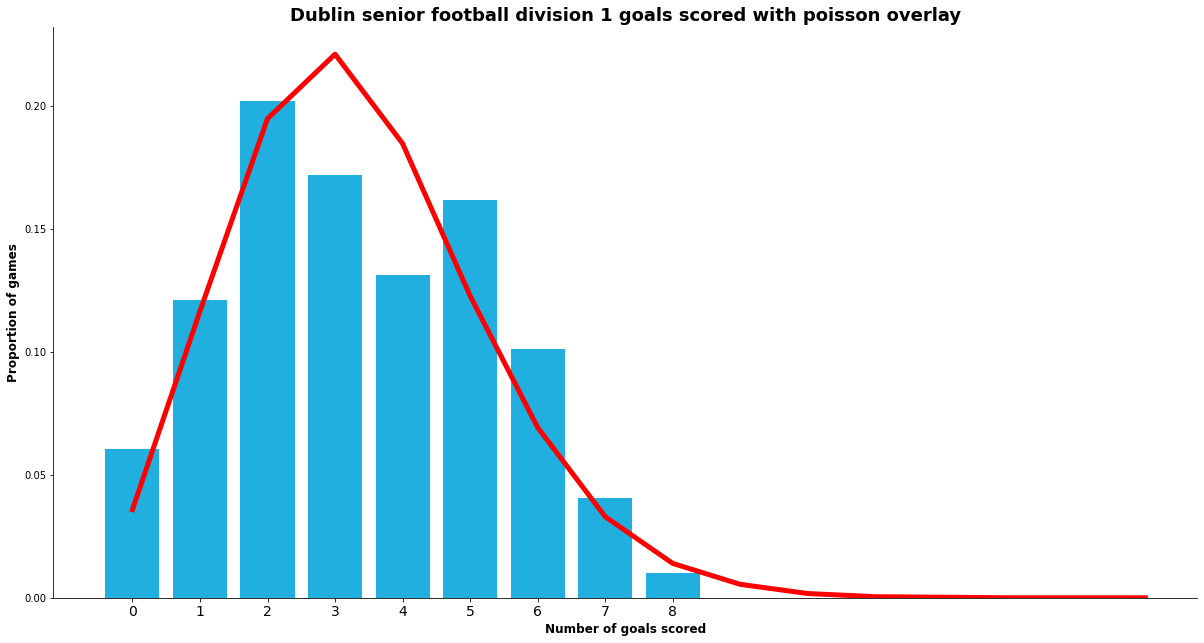

In [6]:
viz_df = gaa_df.groupby('total_goals')['game_id'].count().reset_index()
viz_df.columns = ['total_goals', 'number_of_matches']
viz_df['proportion_of_goals'] = viz_df['number_of_matches']/len(gaa_df)

# generate points distributed according to a poisson distribution to overlay
mean_goals = gaa_df['total_goals'].mean()
poisson_dist = pd.DataFrame({'goals_scored': list(poisson.rvs(mean_goals, size=100000))}).reset_index()
poisson_dist = poisson_dist.groupby('goals_scored')['index'].count().reset_index()
poisson_dist['proportion_of_goals'] = poisson_dist['index']/100000

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot the distribution and overlay
ax = sns.barplot(
    x='total_goals', y='proportion_of_goals', data=viz_df, color='deepskyblue'
)

ax = sns.lineplot(
    x='goals_scored', y='proportion_of_goals', data=poisson_dist, color='red', linewidth=5, markers=True
)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title("Dublin senior football division 1 goals scored with poisson overlay", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel("Number of goals scored", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_ylabel("Proportion of games", fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
plt.savefig('visuals/goals_per_game.png')
fig.show()

# Making some simple predictions for goals & points scored 

Now that we understand how goals and points are distributed, we can use this information to make some simple predictions of how many goals or points a team is expected to score in a given match using the cumulative mass (for normal distribution) and probability density (for poisson) functions.

## Some preliminary data preparation

Before we get stuck into this, we will perform a bit of data transformation to get our GAA dataset into a format that will allow us to calculate each teams average goals and points a bit easier. 

To do this we will simply split the data into home and away dataframes and get each teams score as well as their opponents before adding an `at_home` flag which we will use a bit later for our more advanced model.

In [7]:
home_df = gaa_df[[
    'game_id', 'date', 'time', 'location', 'home_team', 'home_team_goals', 'home_team_points', 'away_team', 'away_team_goals', 'away_team_points'
]]

away_df = gaa_df[[
    'game_id', 'date', 'time', 'location', 'away_team', 'away_team_goals', 'away_team_points', 'home_team', 'home_team_goals', 'home_team_points'
]]

home_df['at_home'] = 1
away_df['at_home'] = 0

home_df.columns = away_df.columns = [
    'game_id', 'date', 'time', 'location', 'team', 'team_goals', 'team_points', 
    'opponent', 'opponent_goals', 'opponent_points', 'at_home'
]

team_results_df = pd.concat([home_df, away_df])
team_results_df.head()

<ipython-input-7-293470c25181>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df['at_home'] = 1
<ipython-input-7-293470c25181>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_df['at_home'] = 0


,game_id,date,time,location,team,team_goals,team_points,opponent,opponent_goals,opponent_points,at_home
0,0,09 Nov,14:00,Martin Savage Park,St Oliver Plunketts ER,3,13,Templeogue Synge Street,1,9,1
1,1,23 Oct,19:30,Lawless Park,Fingallians,3,19,Na Fianna,3,15,1
2,2,19 Oct,16:00,Dolphin Park,Templeogue Synge Street,1,12,Cuala,4,14,1
3,3,19 Oct,16:00,St Mobhi Road,Na Fianna,0,9,St Oliver Plunketts ER,1,12,1
4,4,05 Oct,16:00,Hyde Park,Cuala,7,11,St Maurs,1,5,1


Once we have the data in this format we can very easily calculate each teams average goals and points scored using a pandas aggregation.

In [8]:
team_averages = team_results_df.groupby('team')[['team_goals', 'team_points']].mean().reset_index()
team_averages.columns = ['team', 'average_goals', 'average_points']
team_stds = team_results_df.groupby('team')[['team_goals', 'team_points']].std().reset_index()
team_stds.columns = ['team', 'goals_std', 'points_std']
team_averages = team_averages.merge(team_stds, on = 'team')
team_averages

,team,average_goals,average_points,goals_std,points_std
0,Ballinteer St Johns,1.769231,10.615385,1.091928,3.355057
1,Ballyboden St Endas,3.000000,16.083333,1.279204,2.968267
2,Ballymun Kickhams,2.083333,12.666667,1.928652,2.902455
3,Cuala,2.076923,10.923077,2.139374,2.431102
4,Fingallians,1.461538,10.769231,1.126601,3.370308
5,Kilmacud Crokes,1.909091,13.727273,1.700267,3.289100
6,Lucan Sarsfields,2.153846,14.000000,0.898717,4.636809
7,Na Fianna,1.833333,14.000000,1.337116,3.541956
8,Skerries Harps,0.923077,10.846154,0.862316,3.262058
9,St Brigids,1.083333,11.666667,1.083625,3.143054


## Predicting point probabilities using the normal distribution and it's cumulative density function

Since we are comfortable that our points data is normally distributed we can calculate a basic probability that a team will score less than $x$ points given the average number of points they usually score, and their standard deviation.

From a theoretical perspective, we do this by first calculating the $Z$ score of observing up to $x$ points given the mean ($\mu$) and standard deviation ($\sigma$) where:

$$Z = \frac{X - \mu}{\sigma}$$

From here we look up this $Z$ value in a set of [stats tables](https://www.scss.tcd.ie/~arwhite/Teaching/ST1252/Statistical_Tables.pdf) to determine the probabiltity of observing up to this value ($\Phi(Z)$) such that:

$$P(x < X) = \Phi(Z)$$

**Example:**

What is the probability that Ballyboden St Endas will score less than 16 points in a game?

Here we know that $X = 16$, $\mu = 16.083$, $\sigma = 2.968$.

So:

$$ Z = \frac{16 - 16.083}{2.968} = -0.280$$


$$ P(x < X) = \Phi(Z) = 0.4888$$

In other words there is a probability of 0.49 that Ballyboden will score less than 16 points in a game.

**Why only less than?**

By default the Z score/p-value approach returns the cumulative probability of observing a result (points scored) less that $X$. However if instead we want to calculate the probability that Ballyboden scores 16 or more points we can very easily do this by subtracting the probability of scoring less than 16 from 1 as seen below:

$$P(x >= 16) = 1 - P(x < 16)$$

$$= 1 - 0.4888$$

$$= 0.5222$$

**What if I want to calculate exact point probabilities?**

Unfortunately since the normal distribution is a continous distribution, the probability of observing a particular exact value is 0. We can however calculate the probability of observing a value within a given range. 

For example, if we wanted to calculate the probability of Ballyboden scoring 16 points we could consider this the same as the probability of them scoring between 15.5 and 16.5 points. When we think of it like this, the calculation becomes a lot easier:

$$P(15.5 < X < 16.5) = P(X < 16.5) - P(X < 15.5)$$

### Examples using Python

Thankfully for us, [scipy's norm function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) allows us to quickly calculate the probability of observing particular values in a normal distribution.

In the below examples you will see how we can use this function, along with our data to answer some point probability questions.

#### Whats the probability of  Ballyboden scoring less than 16 points in a game?

In [9]:
team = 'Ballyboden St Endas'
score_less_than = 16

team_avergage = team_averages.loc[team_averages['team']==team, 'average_points'].values[0]
team_std = team_averages.loc[team_averages['team']==team, 'points_std'].values[0]

probabiltity = norm(team_avergage, team_std).cdf(score_less_than)
print(f"Probability: {round(probabiltity, 4)}")

Probability: 0.4888


#### What's the probability of Ballymun scoring more than 15 points in a game? 

In [10]:
team = 'Ballymun Kickhams'
score_more_than = 15

team_avergage = team_averages.loc[team_averages['team']==team, 'average_points'].values[0]
team_std = team_averages.loc[team_averages['team']==team, 'points_std'].values[0]

probabiltity = 1 - norm(team_avergage, team_std).cdf(score_more_than)
print(f"Probability: {round(probabiltity, 4)}")

Probability: 0.2107


#### Whats the probability of Na Fianna scoring more than 14.5. and less than 15.5 points in a game?

In [11]:
team = 'Na Fianna'
score_more_than = 14.5
score_less_than = 15.5

team_avergage = team_averages.loc[team_averages['team']==team, 'average_points'].values[0]
team_std = team_averages.loc[team_averages['team']==team, 'points_std'].values[0]

probabiltity_more_than = norm(team_avergage, team_std).cdf(score_more_than)
probabiltity_less_than = norm(team_avergage, team_std).cdf(score_less_than)
print(f"Probability: {round(probabiltity_less_than, 4) - round(probabiltity_more_than, 4)}")

Probability: 0.1079


## Predicting goal probabilities using the poisson distribution and it's probability mass function

Similarly to the normal distribution, the poisson distribution also allows us to calculate the probability of scoring a particular number of goals given the team's mean number of goals scored. However unlike the normal distribution, the poisson distribution is a discrete distribution which means we can calculate the probability of scoring an exact number of goals.

To calculate the probability of scoring $x$ goals according to the poisson distribution, we can use the following formula:

$$P(x) = \frac{e^{- \lambda}\lambda^x}{x!}$$

Where$\lambda$ the average number of goals scored by the team per game.

**Example:**

What is the probability that Skerries Harps score 3 goals in a match?

$$P(3) = \frac{e^{- 0.923077}0.923077^3}{3!}$$

$$= 0.052$$

**Probability of scoring more than N goals?**

If we want to calculate the probability that a team will score 2 or more goals, this would simply be 1 minus the probability of scoring 0 or 1 goals:

$$P(x >= 2) = 1 - (P(x = 0) + P(x = 1))$$


### Examples using Python

Similar to before, scipy has a handy [poisson function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html) which allows us to easily calculate these probabilities as demonstrated in the examples below

#### What is the probability of Skerries Harps scoring 3 goals in a match? 

In [12]:
team = 'Skerries Harps'
number_of_goals = 3

team_avergage = team_averages.loc[team_averages['team']==team, 'average_goals'].values[0]

probabiltity = poisson.pmf(number_of_goals, team_avergage)
print(f"Probability: {round(probabiltity, 4)}")

Probability: 0.0521


#### Whats the probability of Fingallians scoring more than 2 goals in a match?

In [13]:
team = 'Fingallians'

team_avergage = team_averages.loc[team_averages['team']==team, 'average_goals'].values[0]

probabiltity = 1 - (poisson.pmf(0, team_avergage) + poisson.pmf(1, team_avergage) + poisson.pmf(2, team_avergage))
print(f"Probability: {round(probabiltity, 4)}")

Probability: 0.1816


# Calculating expected goals & points taking into account the opponent and home field advantage 

While the simple approach described above can help us get to grips with the normal/poisson distributions and the idea of predicting goal probabilities, it fails to take into account the quality of the opponent and any home field advantage which may be in play.

We can get around this however by fitting a normal/gaussian regression model  for points (since the response variable is normally distributed),and poisson regression model for goals to predict the expected number of points/goals a team will score against a particular opponent with home field advantage in mind.

Of course we can add any number of variables to this model (e.g. average passes per team, possession, etc.) as they are available, however for the purposes of this tutorial the three mentioned above will suffice.

Thankfully for us, we can very easily fit a  normal or poisson regression using the [statsmodels library](https://www.statsmodels.org/stable/index.html), as demonstrated below.

## Points - normal regression 

We can fit a regression model to predict the number of points a team will score against a particular opponent by passing in the variables from the `team_results_df` we created earlier and specifying the family as `sm.families.Gaussian()`.

In [14]:
normal_model = smf.glm(
    formula="team_points ~ at_home + team + opponent", data=team_results_df, family=sm.families.Gaussian()
).fit()

When we take a look at the output below, the first thing that we notice is that there is a lot of information. However for the purposes of understanding how the predictions will work, the main things we are interested in are the values in the `coeff` column. These values represent what we will pass into the poisson regression model formula to calculate the expected goals a team will score.

**Example:**

Consider we want to put a bet on how many points Ballymun Kickhams will score in a home fixture against Lucan Sarsfields. We would begin by pulling the `intercept`(always included), `team[T.Ballymun Kickhams]`, `opponent[T.Lucan Sarsfields]`, and `at_home` values from the table below (note if the team you want to detrmine the expected points for is playing away you can leave out the `at_home` value).

From here, we can simply plug these in to the **normal regression formula**:

$$ \lambda = E[Y | x] = \theta x$$

Where $\theta$ is the sum of our coefficient values (including the intercept).

Doing this we get:

$$ \lambda = 10.7187 + 1.9499 + 0.4201 + 0.7356 = 13.82$$

Using this data, our model tells us that Ballymun are expected to score 13.82 points against Lucan.

Of course we don't always have to do this by hand as [statsmodels](https://www.statsmodels.org/stable/index.html) provides a handy `predict()` function which we will use in our simulations (see below).

In [15]:
normal_model.predict(
    pd.DataFrame(data={'team': 'Ballymun Kickhams', 'opponent': 'Lucan Sarsfields', 'at_home':1},index=[1])
).values[0]

13.824284078685377

In [16]:
normal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            team_points   No. Observations:                  198
Model:                            GLM   Df Residuals:                      166
Model Family:                Gaussian   Df Model:                           31
Link Function:               identity   Scale:                          9.5616
Method:                          IRLS   Log-Likelihood:                -487.02
Date:                Tue, 13 Oct 2020   Deviance:                       1587.2
Time:                        21:46:48   Pearson chi2:                 1.59e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              10.7187      1.264      8.477      0.000       8.240      13.197
team[T.Ballyboden St Endas]             5.2786      1.253      4.214      0.000       2.823       7.734
team[T.Ballymun Kickhams]               1.9499      1.249      1.562      0.118      -0.497       4.397
team[T.Cuala]                           0.2212      1.224      0.181      0.857      -2.178       2.620
team[T.Fingallians]                     0.5383      1.224      0.440      0.660      -1.861       2.938
team[T.Kilmacud Crokes]                 2.7939      1.286      2.173      0.030       0.274       5.314
team[T.Lucan Sarsfields]                3.3261      1.224      2.717      0.007       0.926       5.726
team[T.Na Fianna]                       3.0826      1.254      2.459      0.014       0.625       5.540
team[T.Skerries Harps]                  0.1332      1.217      0.109      0.913      -2.251       2.517
team[T.St Brigids]                      1.2156      1.253      0.970      0.332      -1.240       3.671
team[T.St Judes]                        2.6122      1.285      2.033      0.042       0.093       5.131
team[T.St Maurs]                       -0.4894      1.253     -0.390      0.696      -2.946       1.967
team[T.St Oliver Plunketts ER]          0.7364      1.224      0.602      0.547      -1.663       3.136
team[T.St Vincents]                     2.7889      1.221      2.285      0.022       0.396       5.181
team[T.Templeogue Synge Street]         0.1894      1.254      0.151      0.880      -2.268       2.647
team[T.Thomas Davis]                    2.9541      1.217      2.428      0.015       0.569       5.339
opponent[T.Ballyboden St Endas]        -2.0220      1.253     -1.614      0.106      -4.477       0.433
opponent[T.Ballymun Kickhams]          -0.5327      1.249     -0.427      0.670      -2.980       1.914
opponent[T.Cuala]                      -1.2116      1.224     -0.990      0.322      -3.610       1.187
opponent[T.Fingallians]                 1.3962      1.224      1.140      0.254      -1.004       3.796
opponent[T.Kilmacud Crokes]            -0.4363      1.286     -0.339      0.734      -2.956       2.083
opponent[T.Lucan Sarsfields]            0.4201      1.224      0.343      0.732      -1.980       2.820
opponent[T.Na Fianna]                  -0.9929      1.254     -0.792      0.428      -3.450       1.464
opponent[T.Skerries Harps]             -0.9358      1.217     -0.769      0.442      -3.320       1.449
opponent[T.St Brigids]                  0.5540      1.253      0.442      0.658      -1.902       3.010
opponent[T.St Judes]                   -3.6114      1.285     -2.810      0.005      -6.130      -1.093
opponent[T.St Maurs]                    0.8578      1.253      0.68

### Examples using python

#### How many points are St Judes expected to score against St Brigids at home?

In [17]:
normal_model.predict(
    pd.DataFrame(data={'team': 'St Judes', 'opponent': 'St Brigids', 'at_home':1},index=[1])
).values[0]

14.620521640991903

####  How many points are St Judes expected to score against St Brigids away from home?

In [18]:
normal_model.predict(
    pd.DataFrame(data={'team': 'St Judes', 'opponent': 'St Brigids', 'at_home':0},index=[1])
).values[0]

13.884878262118631

## Goals - poisson regression 

As with the points data, we can simply fit a poisson regression model using the same variables to make a prediction on the number of goals a team is expected to score against a particular opponent.

In [19]:
poisson_model = smf.glm(
    formula="team_goals ~ at_home + team + opponent", data=team_results_df, family=sm.families.Poisson()
).fit()

**Example:**

Instead of points, lets say we want to know how many goals Ballymun should score against Lucan. Well the process is very similar, and as with before we begin by pulling the `intercept`, `team[T.Ballymun Kickhams]`, `opponent[T.Lucan Sarsfields]`, and `at_home` values from the table below.

From here, we plug these values into the slightly different **poisson regression formula**:

$$ \lambda = E[Y | x] = e^{\theta x}$$

Where once again $\theta$ is the sum of our coefficient values (including the intercept).

Doing this we get:

$$ \lambda = e^{0.5871 + 0.0965 + 0.1415 + 0.1253} = 2.58$$

Calculating the above we can see that our models expects Ballymun to score 2.58 goals against Lucan. This combined with the 13.82 points predicted above should surely be enough to get them the win!

Once again, we can use the `predict()` function to perform these calculations easily in Python.

In [20]:
poisson_model.predict(
    pd.DataFrame(data={'team': 'Ballymun Kickhams', 'opponent': 'Lucan Sarsfields', 'at_home':1},index=[1])
).values[0]

2.5863274203336766

In [21]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             team_goals   No. Observations:                  198
Model:                            GLM   Df Residuals:                      166
Model Family:                 Poisson   Df Model:                           31
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -289.02
Date:                Tue, 13 Oct 2020   Deviance:                       185.38
Time:                        21:46:48   Pearson chi2:                     158.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.5871      0.305      1.925      0.054      -0.011       1.185
team[T.Ballyboden St Endas]             0.4450      0.271      1.644      0.100      -0.085       0.975
team[T.Ballymun Kickhams]               0.0965      0.291      0.331      0.740      -0.474       0.667
team[T.Cuala]                           0.1218      0.287      0.424      0.671      -0.441       0.684
team[T.Fingallians]                    -0.1120      0.314     -0.356      0.722      -0.728       0.504
team[T.Kilmacud Crokes]                -0.0541      0.306     -0.177      0.860      -0.653       0.545
team[T.Lucan Sarsfields]                0.2012      0.285      0.707      0.480      -0.357       0.759
team[T.Na Fianna]                      -0.0529      0.301     -0.176      0.861      -0.644       0.538
team[T.Skerries Harps]                 -0.6905      0.357     -1.934      0.053      -1.390       0.009
team[T.St Brigids]                     -0.4620      0.351     -1.316      0.188      -1.150       0.226
team[T.St Judes]                       -0.5974      0.384     -1.557      0.120      -1.350       0.155
team[T.St Maurs]                        0.1211      0.300      0.404      0.686      -0.466       0.708
team[T.St Oliver Plunketts ER]         -0.4177      0.343     -1.219      0.223      -1.090       0.254
team[T.St Vincents]                     0.1125      0.286      0.394      0.694      -0.448       0.673
team[T.Templeogue Synge Street]        -0.3567      0.336     -1.063      0.288      -1.014       0.301
team[T.Thomas Davis]                   -0.4135      0.326     -1.268      0.205      -1.053       0.226
opponent[T.Ballyboden St Endas]        -0.7705      0.394     -1.955      0.051      -1.543       0.002
opponent[T.Ballymun Kickhams]          -1.0595      0.432     -2.453      0.014      -1.906      -0.213
opponent[T.Cuala]                      -0.2997      0.325     -0.921      0.357      -0.938       0.338
opponent[T.Fingallians]                -0.0521      0.298     -0.175      0.861      -0.636       0.531
opponent[T.Kilmacud Crokes]             0.1400      0.300      0.467      0.641      -0.448       0.728
opponent[T.Lucan Sarsfields]            0.1415      0.286      0.495      0.621      -0.419       0.702
opponent[T.Na Fianna]                  -0.0240      0.303     -0.079      0.937      -0.617       0.569
opponent[T.Skerries Harps]             -0.1494      0.304     -0.492      0.623      -0.744       0.446
opponent[T.St Brigids]                 -0.1011      0.306     -0.331      0.741      -0.700       0.498
opponent[T.St Judes]                   -0.7890      0.394     -2.002      0.045      -1.561      -0.017
opponent[T.St Maurs]                    0.5316      0.265      2.00

### Examples using python 

#### How many goals are Skerries Harps expected to score against St Maurs at home?

In [22]:
poisson_model.predict(
    pd.DataFrame(data={'team': 'Skerries Harps', 'opponent': 'St Maurs', 'at_home':1},index=[1])
).values[0]

1.7392518713712306

#### How many goals are Skerries Harps expected to score against Ballymun away from home?

In [23]:
poisson_model.predict(
    pd.DataFrame(data={'team': 'Skerries Harps', 'opponent': 'Ballymun Kickhams', 'at_home':0},index=[1])
).values[0]

0.3125738185627297

## A note on interpreting the coefficient values 

A couple of quick points to note here regarding the coefficient values before moving on:

1. You will notice that Ballinteer St Johns don't appear anywhere in this summary. This is because they appear first alphabetically in the data and are thus considered to be the intercept for the model. You can think of all other coefficient values as that teams attacking of defensive strength compared to Ballinteer. For example if a team has a positive coefficient value, it will mean they are a superior attacking team to Ballinteer, whereas a team with a negative coefficient can be considered inferior as an attacking threat. Conversely, an opponent with a positive coefficient can be considered a worse team defensively, while an opponent with a negative coefficent can be considered a better defensive team.


2. With point 1 in mind, we can use the coefficient values to rank teams within the league. Since Ballymun have the lowest value in the opponents section of the goals model, we can say they are the best team in the league at defending their goal.

# Simulating results 

Once we have a mechanism for determining the expected number of points/goals a team should score against a particular opponent (described in section 5), and a way to calculate the probability of scoring a $x$ goals or points based on the teams average/expected value (described in section 4), the process for simulating matches between two teams and coming up with outcome probabilities is very straight forward.

## Simulating points 

Lets say we want to run a simulation on a match between Ballymun (at home) and St. Maurs to determine the probabilities that each team scores within a range of points. To do this we would:

1. Calculate how many points Ballymun are expected to score at home versus Maurs (section 5) and the standard deviation


2. Calculate how many points Maurs are expected to score away to Ballymun (section 5) and the standard deviation


3. Iterate through a range of potential point values for both teams (e.g. 0 to 5, 5 to 10, 10 to 15, etc.) and calculate the probability of that event using the formula described in section 4.


4. (Optional) Plot results on heatmap.

Using Python we can very easily do this as we already have most of the code set up, all we need to do is set up a function and have it iterate through different point ranges for both teams.

In [24]:
def simulate_points(normal_model, home_team, away_team):
    
    # Step 1:
    home_team_expected_points = normal_model.predict(
        pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'at_home':1},index=[1])
    )
    home_team_se = normal_model.get_prediction(
        pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'at_home':1},index=[1])
    ).se_mean[0]
    
    #  Step 2:
    away_team_expected_points = normal_model.predict(
        pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'at_home':0},index=[1])
    )
    away_team_se = normal_model.get_prediction(
        pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'at_home':0},index=[1])
    ).se_mean[0]
    
    # Step 3:
    point_ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)]
    
    # a list we will use to store the probabilities
    overall_point_probs = []
    # loop through each team and determine the probability of them scoring within each point range
    for team_expectation in [(home_team_expected_points, home_team_se), (away_team_expected_points, away_team_se)]:
        team_point_probs = []
        expected_points = team_expectation[0]
        team_std = team_expectation[1]
        for point_range in point_ranges:
            probabiltity_less_than = norm(expected_points, team_std).cdf(point_range[0])
            probabiltity_more_than = norm(expected_points, team_std).cdf(point_range[1])
            probability = probabiltity_more_than - probabiltity_less_than
            team_point_probs.append(probability[0])
        
        # add the teams probabilities to the overall list
        overall_point_probs.append(team_point_probs)
    
    return(np.outer(np.array(overall_point_probs[0]), np.array(overall_point_probs[1])))

Plotting the output of this function shows us that the point scoreline with the highest probability is Ballymun scoring between 10-15 points and Maurs scoring between 5-10.

<ipython-input-25-d65a3aca5308>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


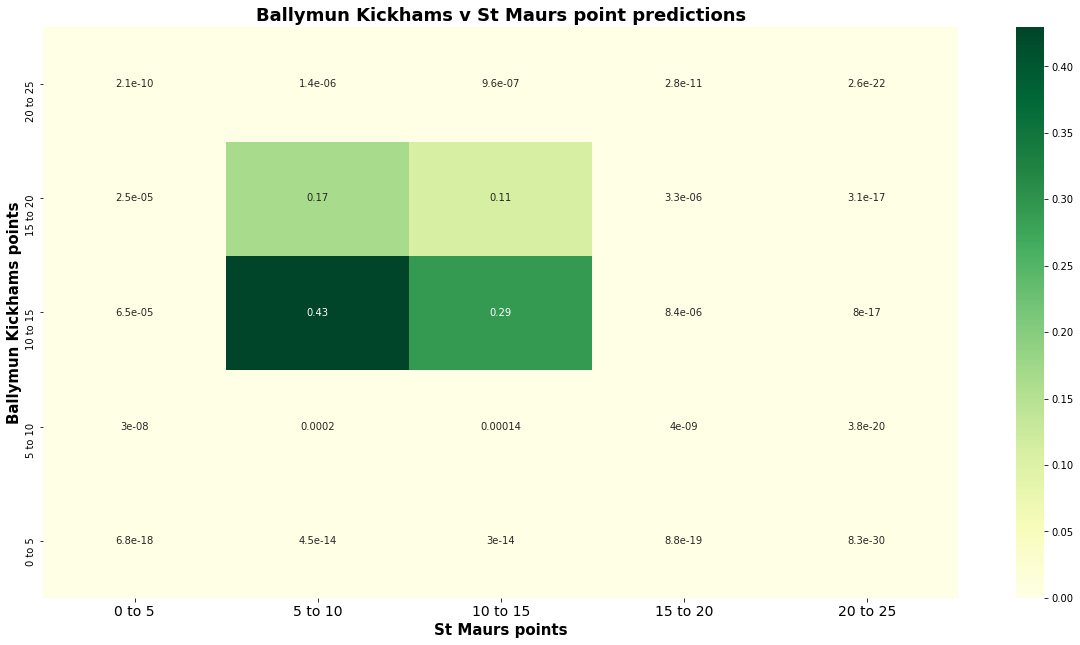

In [25]:
home_team = "Ballymun Kickhams"
away_team = "St Maurs"

match_score_probabilities = simulate_points(
    normal_model, home_team, away_team
)

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot our boxplot and
ax = sns.heatmap(match_score_probabilities, annot=True, cmap="YlGn")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title(f"{home_team} v {away_team} point predictions", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel(f"{away_team} points", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_ylabel(f"{home_team} points", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.invert_yaxis()

labels = [
    '0 to 5', '5 to 10', '10 to 15', '15 to 20', '20 to 25'
]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.savefig('visuals/sample_point_predictions.png')
fig.show()

## Simulating goals 

Since we are not dealing with a continuous distribution, calculating goal probabilities is actually a lot more straight forward. We simply calculate the expected goals for a team against a given opponent (as described in section 5), and plug this value into the poisson formula from section 4 to iteratively calculate the probability of a team scoring 𝑥x goals in the match.

Similarly to before, we will create a function simulate_goals that will do this for us and we will plot the results on a heat map.

In [26]:
def simulate_goals(poisson_model, home_team, away_team, max_goals=5):
    # calculate home team expected goals using our poisson regression model
    home_team_expected_goals = poisson_model.predict(
        pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'at_home':1},index=[1])
    )
    
    # calculate away team expected goals using the same model
    away_team_expected_goals = poisson_model.predict(
        pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'at_home':0},index=[1])
    )
    
    # now loop through all possible goal combinations and determine the probability of that scoreline
    team_goals_prob = [
        [poisson.pmf(i, expected_goals) for i in range(0, max_goals+1)] for expected_goals in [
            home_team_expected_goals, away_team_expected_goals
        ]
    ]
    
    return (np.outer(np.array(team_goals_prob[0]), np.array(team_goals_prob[1])))

When we take a look at the output plotted below we can see that Ballymun are potentially in for a big day when they play Maurs, with a relatively high probability of them scoring 2 or more goals while conceding none!

<ipython-input-27-e6dabe116314>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


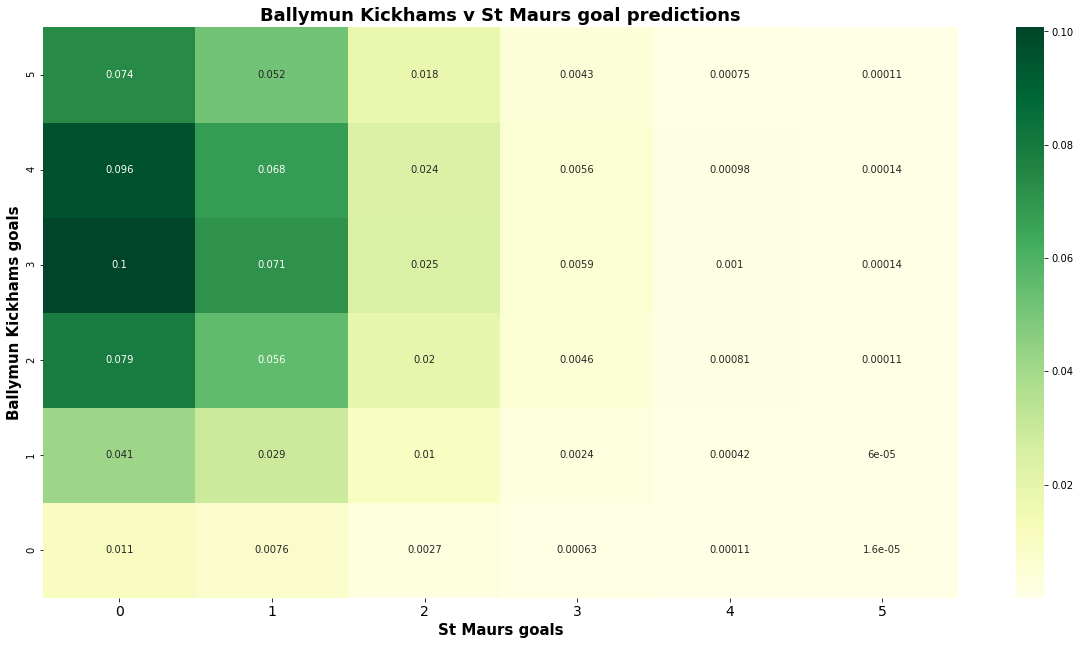

In [27]:
home_team = "Ballymun Kickhams"
away_team = "St Maurs"

match_score_probabilities = simulate_goals(
    poisson_model, home_team, away_team
)

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)

# plot our boxplot and
ax = sns.heatmap(match_score_probabilities, annot=True, cmap="YlGn")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set and format titles
ax.set_title(f"{home_team} v {away_team} goal predictions", fontdict={'fontsize':18, 'fontweight':'bold'})
ax.set_xlabel(f"{away_team} goals", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_ylabel(f"{home_team} goals", fontdict={'fontsize':15, 'fontweight':'bold'})
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.invert_yaxis()

plt.savefig('visuals/sample_goal_predictions.png')
fig.show()

## Simulate full match 

For the purposes of simplifying this tutorial, let us assume that scoring a point and scoring a goal are independant events (i.e. scoring a point has no influence on you scoring a goal and vice versa). 

With this assumption we can very easily calculate the probability of a team scoring $x$ goals and $y$ points in a game as:

$$P(goals = x \cap points = y) = P(goals = x) * P(points = y)$$

With this information we can simulate all possible outcomes for a match between two teams and calculate the probability of either team winning. We will do this by:

1. Determine the expected goals and points for each team in the match
2. iterate over all possible goal and point combinations (within reason) and determine the probabilities of those for both teams
3. Convert these goal and point combinations into total points (i.e. total points = 3*goals + points) 
4. For each total point possibility determine the probability of the team achieving that total (e.g. the probability of scoring 3 total points is the probability of scoring 1 goal and 0 points + the probability of scoring 0 goals and 3 points)
5. Create an NxN probability matrix of all possible outcomes
6. Determine probability of home team winning by summing everything below the diagonal
7. Determine the probability of a draw by summing the diagonal
8. Determine probability of away team winning by summing everything above the diagonal.

We can wrap the above up in a function which will take two team names and determine the probability of either team winning the match.

In [28]:
def get_team_expected_goals(team, opponent, at_home, goals_model=poisson_model):
    
    team_expected_goals = goals_model.predict(
        pd.DataFrame(data={'team': team, 'opponent': away_team, 'at_home':at_home},index=[0])
    ).iloc[0]
    
    return team_expected_goals

In [29]:
def get_team_expected_points(team, opponent, at_home, points_model=normal_model):
    
    # calculate home team expected points and standard error using the normal model
    team_expected_points = points_model.predict(
        pd.DataFrame(data={'team': team, 'opponent': opponent, 'at_home': at_home},index=[1])
    ).iloc[0]
    team_se = points_model.get_prediction(
        pd.DataFrame(data={'team': team, 'opponent': opponent, 'at_home': at_home},index=[1])
    ).se_mean[0]
    
    return (team_expected_points, team_se)

In [30]:
def simulate_match(home_team, away_team, max_goals=10, max_points=35):
    
    # Step 1:
    home_team_expected_goals = get_team_expected_goals(home_team, away_team, 1)
    home_team_expected_points = get_team_expected_points(home_team, away_team, 1)
    home_team_expectation = {
        'team': home_team, 'expected_goals': home_team_expected_goals, 'expected_points': home_team_expected_points
    }
    
    away_team_expected_goals = get_team_expected_goals(away_team, home_team, 0)
    away_team_expected_points = get_team_expected_points(away_team, home_team, 0)
    away_team_expectation = {
        'team': away_team, 'expected_goals': away_team_expected_goals, 'expected_points': away_team_expected_points
    }    

    # Step 2:
    # loop through all goal and point combinations and determne probability and winner
    simulation_df = pd.DataFrame()
    index=0
    for expectation in [home_team_expectation, away_team_expectation]:
        for goal in range(max_goals+1):
            goal_prob = poisson.pmf(goal, expectation['expected_goals'])
            for point in range(max_points+1):
                # remember we cant predict exact numbers usng 
                probabiltity_more_than = norm(expectation['expected_points'][0], expectation['expected_points'][1]).cdf(point-0.5)
                probabiltity_less_than = norm(expectation['expected_points'][0], expectation['expected_points'][1]).cdf(point+0.5)
                point_prob = probabiltity_less_than - probabiltity_more_than
                
                scoreline_dict = {
                    'team': expectation['team'],
                    'goal': goal,
                    'goal_prob': goal_prob,
                    'point': point,
                    'point_prob': point_prob,
                    'total_score': (goal*3) + point,
                    'total_prob': goal_prob * point_prob
                }
                
                simulation_df = simulation_df.append(pd.DataFrame(scoreline_dict, index=[index]))
                index+=1
    # Step 3:           
    # now lets aggregate up to team and total score level
    # since a team can achieve a total score multiple ways, the probability of achieveing that score
    # is the sum of the probabilities of those ways
    simulation_df = simulation_df.groupby(['team', 'total_score'])['total_prob'].sum().reset_index()
    
    # Steph 4
    # now lets create an n x n matrix of score probabilities
    home_team_probs = np.array(
       simulation_df.loc[simulation_df['team']==home_team].sort_values(by='total_score')['total_prob']
    )

    away_team_probs = np.array(
        simulation_df.loc[simulation_df['team']==away_team].sort_values(by='total_score')['total_prob']
    )
    
    # Step 5
    # here is the nxn
    result_probs = np.outer(home_team_probs, away_team_probs)
    # now we can get win probabilities by looking:
    #     - anything left of diagonal implies home team win
    #     - along diagonal ipmplies draw
    #     - right of diagonal implies away team win
    
    # Step 6, 7, & 8
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_team_win_prob': np.sum(np.tril(result_probs, -1)),
        'draw_prob': np.sum(np.diag(result_probs)),
        'away_team_win_prob': np.sum(np.triu(result_probs, 1))
    }

Running the function defined above across a number of matches, as demonstrated below, will give us the probability each team has of winning based on all possible outcomes.

In [31]:
matches = [
    ("Ballymun Kickhams", "Skerries Harps"),
    ("St Judes", "Kilmacud Crokes"),
    ("Ballinteer St Johns", "St Vincents"),
    ("Fingallians", "Ballyboden St Endas"),
    ("St Maurs", "St Oliver Plunketts ER"),
]

for match in matches:
    sim_result = simulate_match(match[0], match[1])
    print(f"{match[0]} v {match[1]}")
    print(f"Probability of {sim_result['home_team']} win: {round(sim_result['home_team_win_prob'], 2)}")
    print(f"Probability of draw: {round(sim_result['draw_prob'], 2)}")
    print(f"Probability of {sim_result['away_team']} win: {round(sim_result['away_team_win_prob'], 2)}\n\n")

Ballymun Kickhams v Skerries Harps
Probability of Ballymun Kickhams win: 0.89
Probability of draw: 0.03
Probability of Skerries Harps win: 0.09


St Judes v Kilmacud Crokes
Probability of St Judes win: 0.52
Probability of draw: 0.06
Probability of Kilmacud Crokes win: 0.42


Ballinteer St Johns v St Vincents
Probability of Ballinteer St Johns win: 0.32
Probability of draw: 0.05
Probability of St Vincents win: 0.63


Fingallians v Ballyboden St Endas
Probability of Fingallians win: 0.06
Probability of draw: 0.02
Probability of Ballyboden St Endas win: 0.91


St Maurs v St Oliver Plunketts ER
Probability of St Maurs win: 0.61
Probability of draw: 0.05
Probability of St Oliver Plunketts ER win: 0.34




# Closing thoughts

While this tutorial focused on the domain of Gaelic football, the methodology described can be applied across a number of sports and I would encourage readers to build their own models for other sports. For example, you could build a poisson model to simulate soccer matches, a normal model to simulate basketball matches, or if you want more practice combining both models you could scrape some hurling data and build a model for hurling.

If the data is available for your chosen sport, I would encourage you to explore the idea of including additional predictors in your linear models such as average possession per game or number of passes per game per team as these could improve model results. If you are focusing on this dataset, you may try excluding the `at_home` variable (which isn't statistically significant) and see how different the predictions are.